# Traitement d'image

In [1]:
# bibliothèques nécessaire au programme

import cv2
import os
import tkinter as tk
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter import messagebox
import numpy as np
import matplotlib.pyplot as plt
import configparser

In [2]:
#Fonction de resize d'image principalement utilisé pour l'affichage des images dans la fenêtre
def resize_image(image):
    
    # Vérifier le type de couleur de l'image
    if image is None:
        print("Impossible de charger l'image.")
    elif len(image.shape) == 2:
        height, width = image.shape
    elif image.shape[2] == 3:
        height, width, channels = image.shape
    elif image.shape[2] == 4:
        height, width, channels = image.shape[:3]
    else:
        print("Le type de couleur de l'image est inconnu.")

    print("Taille image : ",width, "x", height)
    if width > 768 or height > 576:
        # Calculer le ratio de redimensionnement
        ratio = min(768 / width, 576 / height)

        # Redimensionner l'image avec le ratio
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        image = cv2.resize(image, (new_width, new_height))
    return image

In [3]:
#Fonction d'affichage de l'image dans la fenêtre
def affiche_image(image,titre_fenetre):
    image=resize_image(image)   #Permet de réduire l'image avant de l'afficher
    cv2.imshow(titre_fenetre, image)
    

In [4]:
#fonction d'ouverture de fichier avec fenêtre windows
def select_file():
    # Créer une fenêtre Tkinter invisible
    root = Tk()
    root.withdraw()

    # Ouvrir la boîte de dialogue de sélection de fichier avec le chemin par défaut
    file_path = askopenfilename()

    # Fermer la fenêtre Tkinter
    root.destroy()

    # Renvoyer le chemin et le nom du fichier sélectionné
    return file_path

In [5]:
#Fonction principale de calcul du barycentre
def calculate_barycenter(image):
        
    cx, cy,height, width  = barycentre(image)

    output_image = np.zeros((height, width, 3), dtype=np.uint8)
    output_image[:,:]=image

    # Afficher les coordonnées du barycentre
    print("Coordonnées du barycentre:")
    print("x =", cx)
    print("y =", cy)
    print("Point vert dans l'image")
    
    # Dessiner un cercle sur l'image pour représenter le barycentre
    taille=int(height/100)
    output_image = cv2.circle(output_image.copy(), (cx, cy), taille, (0, 255, 0), -1)
    plt.imshow(output_image,cmap='gray')
    plt.colorbar()
    plt.title("Barycentre")
    plt.show()
    return 


In [6]:
#Fonction de calcul du barycentre
def barycentre(image):

    #passage de l'image en niveau de gris
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = image_grey.shape
    
    # Calculer les moments de l'image
    moments = cv2.moments(image_grey)

    # Calculer les coordonnées du barycentre
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])

    return cx,cy,height,width 

In [7]:
#Fonctin de binarisation
def binarisation(image,seuil):
    output_image=duplication_image(image)
    _, image_binarisee = cv2.threshold(output_image, seuil, 255, cv2.THRESH_BINARY)
    #affichage de l'image
    plt.imshow(image_binarisee)
    plt.title("Image binarisee")
    plt.show()
    return image_binarisee   

In [8]:
#Fonction de fermeture des fenêtres images
def close_windows():
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [9]:
#Fonction de calcul de la FTM
def calculate_fourier_transform(image):
    #passage de l'image en niveau de gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel_size_mm = 0.0064
    
    # Calculer la transformée de Fourier
    fourier_transform = np.fft.fftshift(np.fft.fft2(image))

    # Calculer les fréquences spatiales en cycles par pixel
    freq_x = np.fft.fftfreq(image.shape[1], d=pixel_size_mm)
    freq_y = np.fft.fftfreq(image.shape[0], d=pixel_size_mm)

    # Calculer les fréquences spatiales en cycles par mm
    freq_x_mm = freq_x * image.shape[1]
    freq_y_mm = freq_y * image.shape[0]

    # Calculer la fonction de transfert optique en amplitude
    optical_transfer_function = np.abs(fourier_transform)

    # Afficher la fonction de transfert optique en cycles par mm
    plt.imshow(optical_transfer_function, extent=(freq_x_mm.min(), freq_x_mm.max(), freq_y_mm.min(), freq_y_mm.max()), cmap='hot')
    plt.colorbar()
    plt.title("Fonction de transfert optique (cycles/mm)")
    plt.xlabel("Fréquence spatiale X (cycles/mm)")
    plt.ylabel("Fréquence spatiale Y (cycles/mm)")
    plt.show()

    # Calculer le spectre de magnitude
    spectrum = np.abs(fourier_transform)

     # Obtenir la ligne du milieu du spectre
    middle_row = spectrum[spectrum.shape[0] // 2, :]

    # Ne prendre que la moitié de la ligne du milieu
    half_length = len(middle_row) // 2
    middle_row_half = middle_row[half_length+1:]

    # Créer un graphique pour afficher la moitié de la ligne du milieu
    plt.plot(middle_row_half)
    plt.title("Fonction de transfere optique")
    plt.xlabel("Position")
    plt.ylabel("Magnitude")
    plt.show() 

In [10]:
#Fonction de calcul et d'affichage de l'histogramme
def plot_histogram(image):
    #passage de l'image en niveau de gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    # Calculer l'histogramme de l'image
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Afficher l'histogramme
        # Ajuster la taille de l'image du graphique
    fig, ax = plt.subplots(figsize=(18, 3))

    # Afficher l'histogramme en mode bar graph
    ax.bar(np.arange(256), histogram[:, 0], color='blue')
    ax.set_title("Histogramme de l'image")
    ax.set_xlabel("Niveau de gris")
    ax.set_ylabel("Nombre de pixels")
    plt.show()

In [11]:
#Fonction de lecture du fichier de configuration pour extraction des valeurs de ROI
def parse_configuration_file_ROI(config_file_path,section):
    # Créer un objet ConfigParser
    config = configparser.ConfigParser()
    
    # Lire le fichier de configuration
    config.read(config_file_path)
    
    # Extraire les valeurs numériques
    ROI_offset_X = int(config.get(section, 'ROI_X_offset'))
    ROI_offset_Y = int(config.get(section, 'ROI_Y_offset'))
    ROI_largeur = int(config.get(section, 'ROI_largeur'))
    ROI_hauteur = int(config.get(section, 'ROI_hauteur'))

    # Afficher les valeurs extraites
    print("ROI_X_offset :", ROI_offset_X)
    print("ROI_Y_offset :", ROI_offset_Y)
    print("ROI_largeur :", ROI_largeur)
    print("ROI_hauteur :", ROI_hauteur)
    return ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur

In [12]:
#Fonction de lecture du fichier de configuration pour extraction d'une valeur generique
def parse_configuration_file_generique(config_file_path,section,paramettre):
    # Créer un objet ConfigParser
    config = configparser.ConfigParser()
    
    # Lire le fichier de configuration
    config.read(config_file_path)
    
    # Extraire les valeurs numériques
    valeur_paramettre = int(config.get(section, paramettre))


    # Afficher les valeurs extraites
    print("Section :", section)
    print("Paramettre :", paramettre)
    print("Valeur :", valeur_paramettre)

    return valeur_paramettre

In [13]:
#Fonction d'affichage d'un popup
def show_popup(message):
    # Créer une fenêtre principale tkinter
    root = tk.Tk()
    root.withdraw()

    # Afficher la fenêtre pop-up avec le message
    messagebox.showinfo("Popup", message)


In [14]:
#Fonction de fabrication de l'image ROI
def Make_ROI(input_image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur):

    #Vérifie que la ROI est correcte
    height,width = taille_image(input_image)
    print("ROI" , ROI_largeur+ROI_offset_X,width,ROI_hauteur+ROI_offset_Y,height)
    if (ROI_largeur+ROI_offset_X)>width or (ROI_hauteur+ROI_offset_Y)>height :
        print("Erreur dans l'extraction de la ROI")
        return input_image
    else:

        # Découper la région d'intérêt (ROI) de l'image d'entrée
        roi = input_image[ROI_offset_Y:ROI_offset_Y+ROI_hauteur, ROI_offset_X:ROI_offset_X+ROI_largeur]

        print ("Création nouvelle image : ", ROI_hauteur, "x", ROI_largeur)
        # Créer une nouvelle image vide avec la taille de la région d'intérêt
        output_image = np.zeros((ROI_hauteur, ROI_largeur, 3), dtype=np.uint8)

        # Coller la région d'intérêt dans la nouvelle image
        output_image[:,:] = roi

        return output_image

In [15]:
#Fonction d'extraction d'une ligne dans l'image
def extract_line(image, y):

    # Extraire la ligne de l'image
    line = image[y, :]

    return line

In [16]:
#Fonction de mesure de luminance
def mesure_luminance (image,mode,num_ligne):
    #Convertion de l'image en niveaux 
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Définition des lignes de mesures à 1/4 1/2 et 3/4 de l'image avec affichage de ces lignes dans l'image
    height, width = image_grey.shape

    # Duplique l'image d'origine
    output_image=duplication_image(image)

    if num_ligne==None :
        y1=int(height/4)
        y2=int(height/2)
        y3=int(height*3/4)
        start_point = (100, 100)
        end_point = (500, 300)
        output_image = cv2.line(output_image, (0,y1), (width,y1), (255,0,0), 2)
        output_image = cv2.line(output_image, (0,y2), (width,y2), (0,255,0), 2)
        output_image = cv2.line(output_image, (0,y3), (width,y3), (0,0,255), 2)
    else:
        output_image = cv2.line(output_image, (0,num_ligne), (width,num_ligne), (255,255,0), 1)
    plt.imshow(output_image,cmap='gray')
    plt.colorbar()
    plt.title("Identification des lignes de mesure")
    plt.show()

    #extraction de chaque ligne et affichage dans le graph
    if num_ligne==None:
        ligne=extract_line(image_grey,y1)
        plt.plot(ligne, color='red')
        print("Max ligne Rouge :", max(ligne), " à la position :", np.argmax(ligne))

        ligne=extract_line(image_grey,y2)
        plt.plot(ligne, color='green')
        print("Max ligne Verte :", max(ligne), " à la position :", np.argmax(ligne))

        ligne=extract_line(image_grey,y3)
        plt.plot(ligne, color='blue')
        print("Max ligne Bleue :", max(ligne), " à la position :", np.argmax(ligne))
    else:
        ligne=extract_line(image_grey,num_ligne)
        plt.plot(ligne, color='yellow')
        print("Max ligne jaune :", max(ligne), " à la position :", np.argmax(ligne))

    plt.title('Extraction de lignes')
    plt.xlabel('Position')
    plt.ylabel('Intensité')
    plt.show()

    
    #Calcul d'une ligne qui contient la moyenne des colonnes
    for col in range(width):
        column_sum = np.mean(image_grey[:, col])
        ligne[col] = column_sum

    plt.plot(ligne)
    plt.title('Moyenne des lignes verticales')
    plt.xlabel('Position')
    plt.ylabel('Intensité')

    # Afficher le graphique
    plt.show()
    print("Max ligne moyenne :", max(ligne), " à la position :", np.argmax(ligne))

    #Affichage d'un zoom à 20pixel autour du point maximum
    min_graph = np.argmax(ligne)-20
    max_graph = np.argmax(ligne)+20

    min_graph = max(min_graph,0)
    max_graph = min(max_graph,width)
    
    plt.bar(np.arange(width), ligne, color='blue')
    for i in range(min_graph,max_graph):
        plt.text(i, ligne[i], ligne[i])

    print("Zoom à 20 pixels de chaque coté du pic max")

    plt.title('Moyenne des lignes verticales')
    plt.xlabel('Position')
    plt.ylabel('Intensité')
    plt.xlim(min_graph, max_graph)
    # Afficher le graphique

    plt.show()

In [17]:
#Fonction d'affichage de la ROI dans l'image d'origine
def visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur):

    # Duplique l'image d'origine
    ROI_image=duplication_image(image)
    # trace un rectangle de la taille de la ROI
    cv2.rectangle(ROI_image, (ROI_offset_X, ROI_offset_Y), (ROI_offset_X+ROI_largeur, ROI_offset_Y+ROI_hauteur), (255, 0, 255), 2)
    #affiche l'image
    plt.imshow(ROI_image,cmap='gray')
    plt.colorbar()
    plt.title("Localisation ROI")
    plt.show()
    

In [18]:
#Fonction de duplication d'une image
def duplication_image(image):
    height,width = taille_image(image)
    output_image = np.zeros((height, width, 3), dtype=np.uint8)
    output_image[:,:]=image
    return output_image

In [19]:
#Fonction de lecture du fichier de fonfiguration
def affichage_fichier_conf(config_path):
    print ("Fichier de configuration", config_path)
    # Créer un objet ConfigParser
    config = configparser.ConfigParser()

    # Lire le fichier de configuration
    config.read(config_path)
    for section in config.sections():
        print(f"[{section}]")
        for key, value in config.items(section):
            print(f"{key} = {value}")


In [20]:
#Fonction de mesure de la taille des images
def taille_image(image):
    if image is None:
        print("Impossible de charger l'image.")
    elif len(image.shape) == 2:
        height, width = image.shape
    elif image.shape[2] == 3:
        height, width, channels = image.shape
    elif image.shape[2] == 4:
        height, width, channels = image.shape[:3]
    else:
        print("Le type de couleur de l'image est inconnu.")
    return height,width

## Initialisation du programme

In [21]:

show_popup("Ouverture du fichier image")
image_path = select_file()
print("Ouverture fichier image :", image_path)
image = cv2.imread(image_path)
print ("Affichage image plein format")
affiche_image(image,"Image redimensionnee")

show_popup("Ouverture du fichier de configuration")
config_path = select_file()

affichage_fichier_conf(config_path)


Ouverture fichier image : C:/Users/TO52797/Desktop/Traitement image/image.TIF
Affichage image plein format
Taille image :  5120 x 3840
Fichier de configuration C:/Users/TO52797/Desktop/Traitement image/configuration.ini
[Barycentre]
roi_x_offset = 2448
roi_y_offset = 1838
roi_largeur = 224
roi_hauteur = 164
[Histogramme]
roi_x_offset = 2448
roi_y_offset = 1838
roi_largeur = 224
roi_hauteur = 164
[FTM]
roi_x_offset = 2448
roi_y_offset = 1838
roi_largeur = 224
roi_hauteur = 164
[Luminance]
roi_x_offset = 2448
roi_y_offset = 1838
roi_largeur = 224
roi_hauteur = 164
ligne_luminance_roi = 120
[Binarisation]
roi_x_offset = 2448
roi_y_offset = 1838
roi_largeur = 224
roi_hauteur = 164
seuil = 25


## Barycentre
### Barycentre sur image complète

Coordonnées du barycentre:
x = 2122
y = 1766
Point vert dans l'image


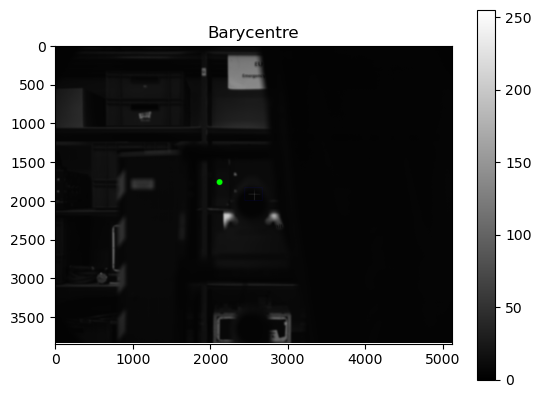

In [22]:
calculate_barycenter(image)

### Barycentre sur ROI

ROI_X_offset : 2448
ROI_Y_offset : 1838
ROI_largeur : 224
ROI_hauteur : 164


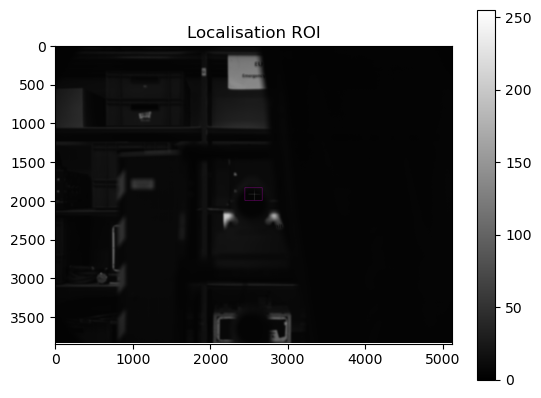

ROI 2672 5120 2002 3840
Création nouvelle image :  164 x 224
Coordonnées du barycentre:
x = 118
y = 72
Point vert dans l'image


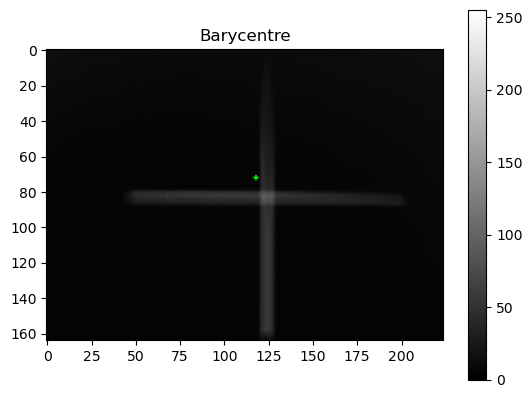

In [23]:
ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur=parse_configuration_file_ROI(config_path,"Barycentre")
visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_ROI_barycentre=Make_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
calculate_barycenter(image_ROI_barycentre)

## Histogramme
### Histogramme sur image complète

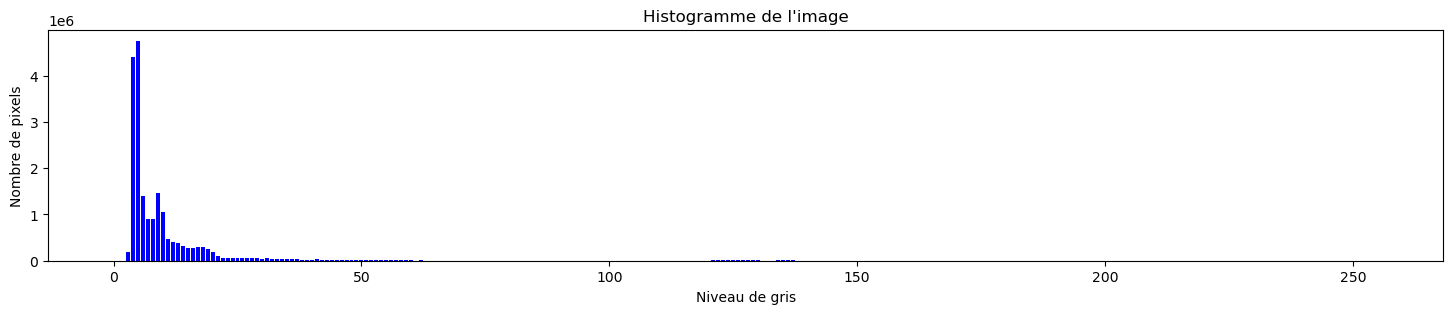

In [24]:
#Calcul de l'histogramme
plot_histogram(image)

### Histogramme sur ROI

ROI_X_offset : 2448
ROI_Y_offset : 1838
ROI_largeur : 224
ROI_hauteur : 164


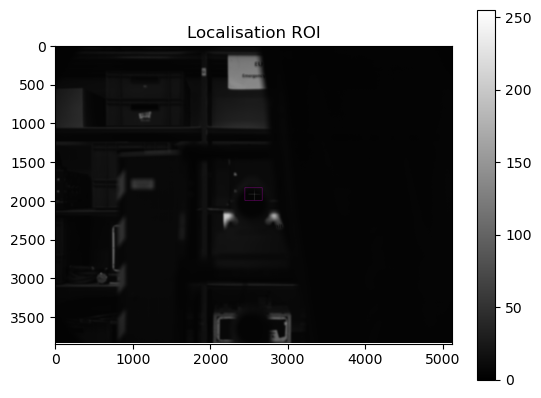

ROI 2672 5120 2002 3840
Création nouvelle image :  164 x 224


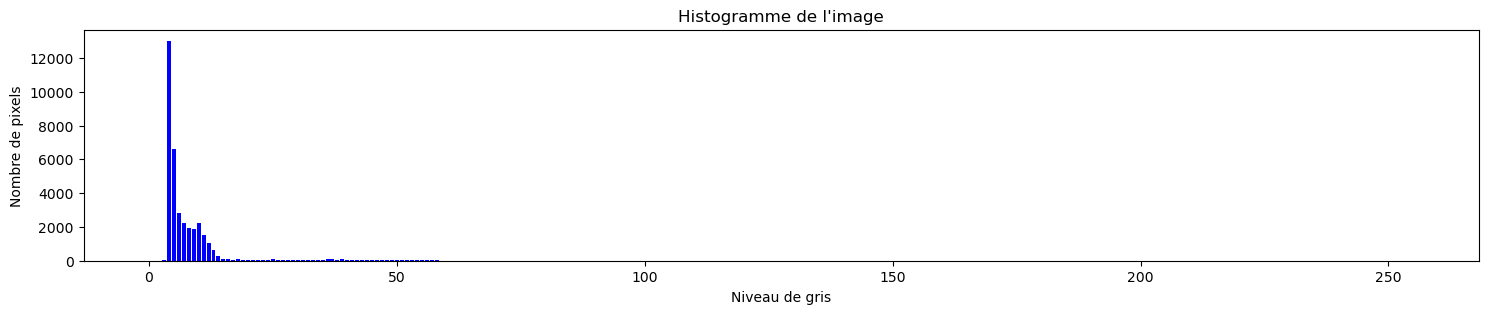

In [25]:
#Calcul de l'histogramme sur la ROI Histogramme
ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur=parse_configuration_file_ROI(config_path,"Histogramme")
visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_ROI_histogramme=Make_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
plot_histogram(image_ROI_histogramme)

## Mesure de luminance
### Luminance sur image complète

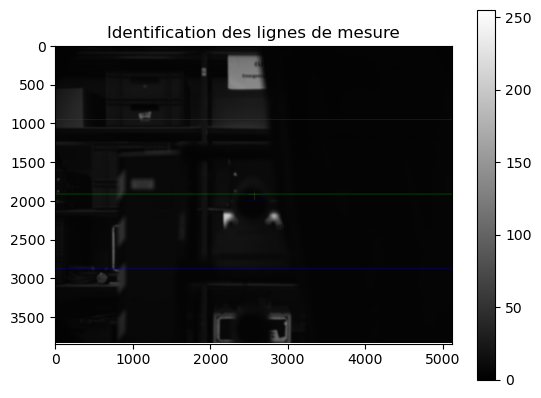

Max ligne Rouge : 48  à la position : 1110
Max ligne Verte : 89  à la position : 2571
Max ligne Bleue : 55  à la position : 752


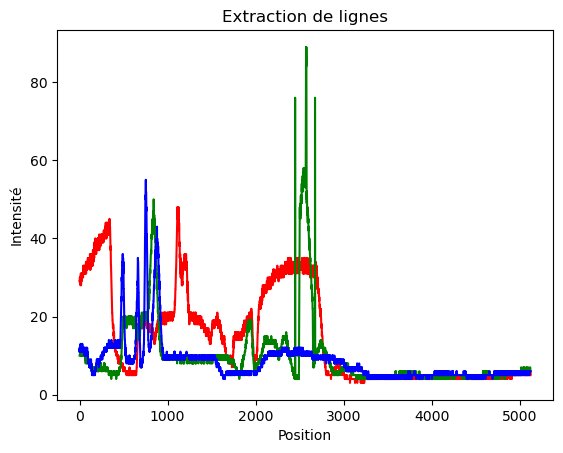

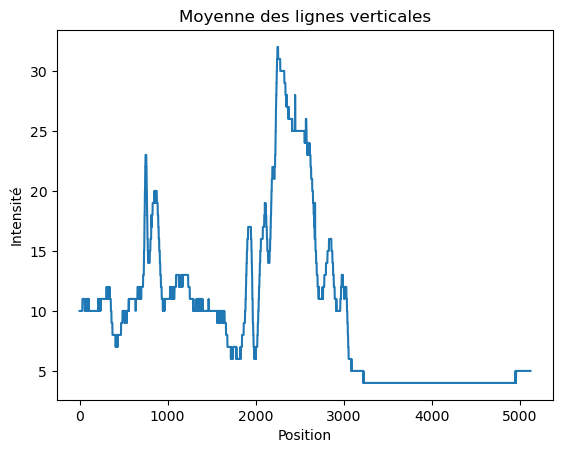

Max ligne moyenne : 32  à la position : 2246
Zoom à 20 pixels de chaque coté du pic max


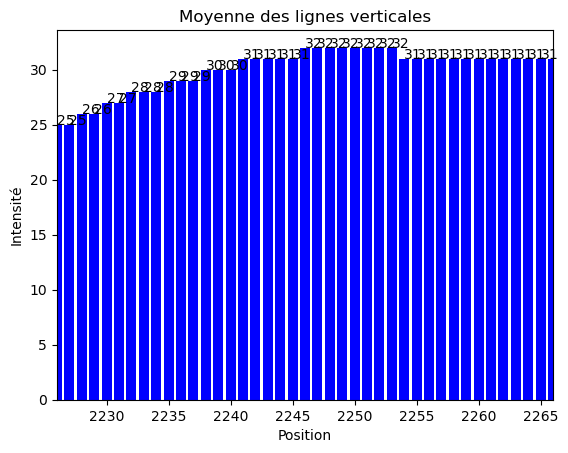

In [26]:
#Calcul de la luminance
mesure_luminance (image,"image",None)

### Luminance sur ROI

ROI_X_offset : 2448
ROI_Y_offset : 1838
ROI_largeur : 224
ROI_hauteur : 164


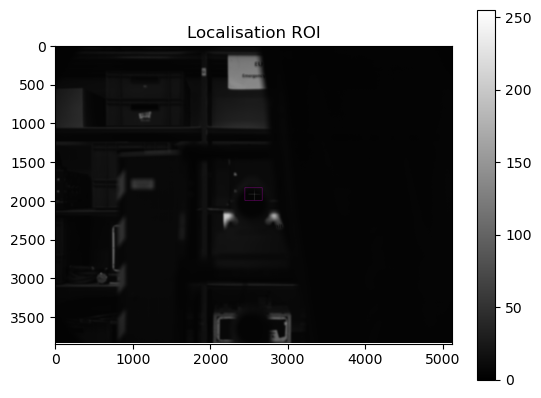

ROI 2672 5120 2002 3840
Création nouvelle image :  164 x 224
Section : Luminance
Paramettre : Ligne_luminance_ROI
Valeur : 120


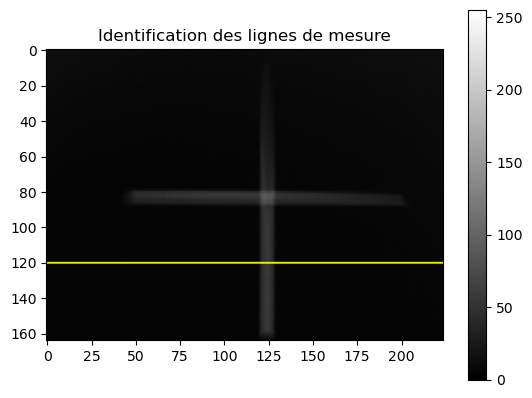

Max ligne jaune : 54  à la position : 124


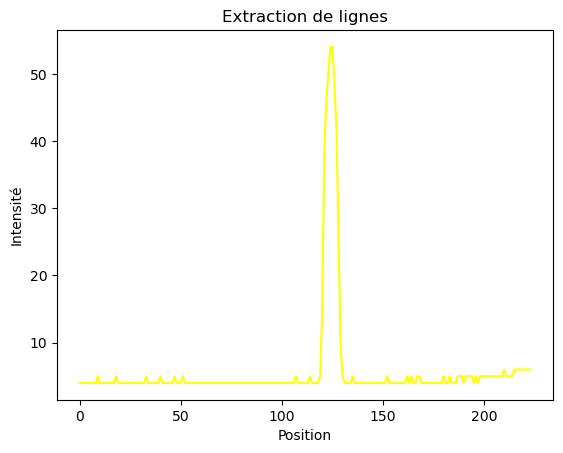

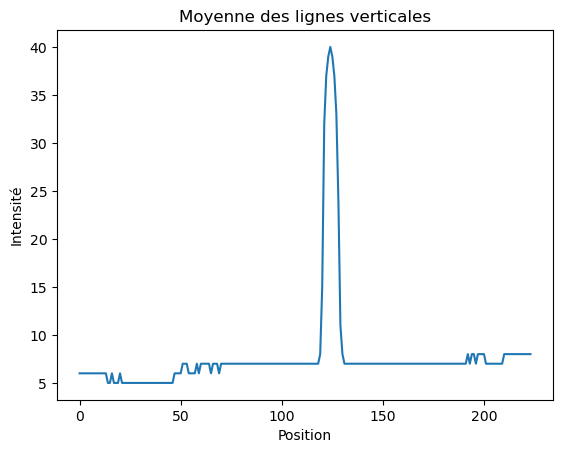

Max ligne moyenne : 40  à la position : 124
Zoom à 20 pixels de chaque coté du pic max


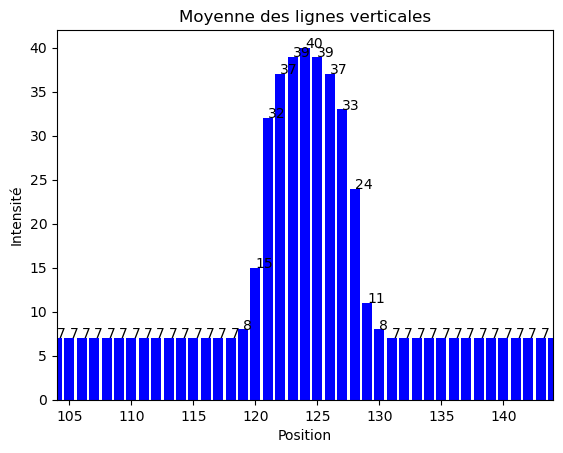

In [27]:
#Calcul de la luminance sur ROI
ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur=parse_configuration_file_ROI(config_path,"Luminance")
visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_ROI_luminance=Make_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
num_ligne=parse_configuration_file_generique(config_path,"Luminance","Ligne_luminance_ROI")
mesure_luminance (image_ROI_luminance,"image",num_ligne)

## Binarisation
###  Binarisation image complète
####   Binarisation

Section : Binarisation
Paramettre : Seuil
Valeur : 25


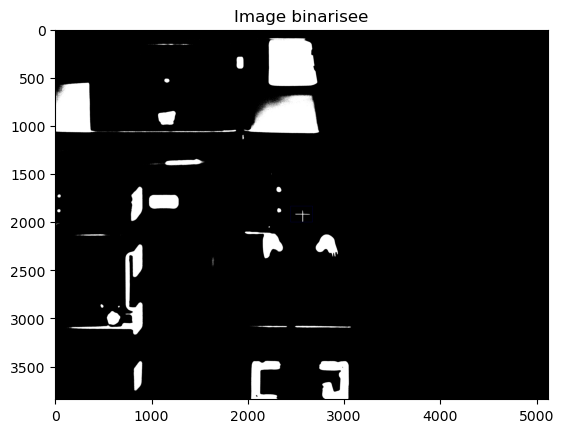

In [28]:

seuil=parse_configuration_file_generique(config_path,"Binarisation","Seuil")
image_binarisee=binarisation(image,seuil)

#### Barycentre sur binarisation

Coordonnées du barycentre:
x = 1738
y = 1548
Point vert dans l'image


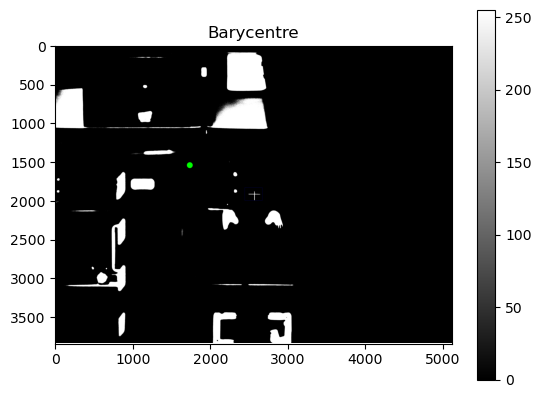

In [29]:

calculate_barycenter(image_binarisee)

### Binarisation sur ROI
#### Binarisation

ROI_X_offset : 2448
ROI_Y_offset : 1838
ROI_largeur : 224
ROI_hauteur : 164


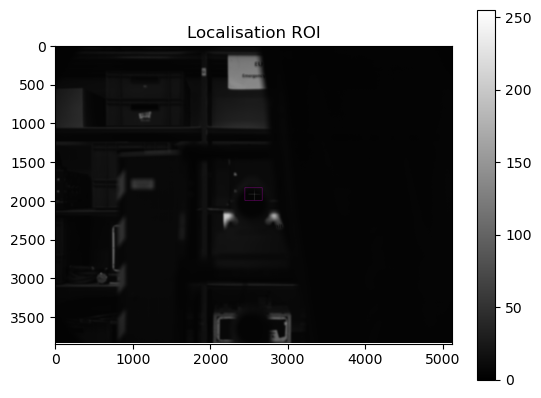

ROI 2672 5120 2002 3840
Création nouvelle image :  164 x 224


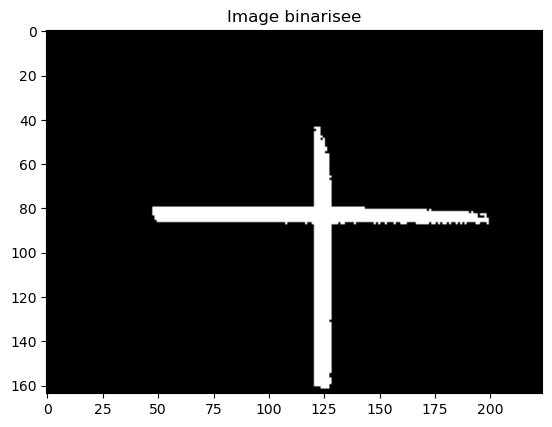

In [30]:
#Calcul de la binarisation sur ROI
ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur=parse_configuration_file_ROI(config_path,"Binarisation")
visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_ROI_binarisation=Make_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_binarisee=binarisation(image_ROI_binarisation,seuil)

#### Barycentre sur binarisation ROI

Coordonnées du barycentre:
x = 121
y = 93
Point vert dans l'image


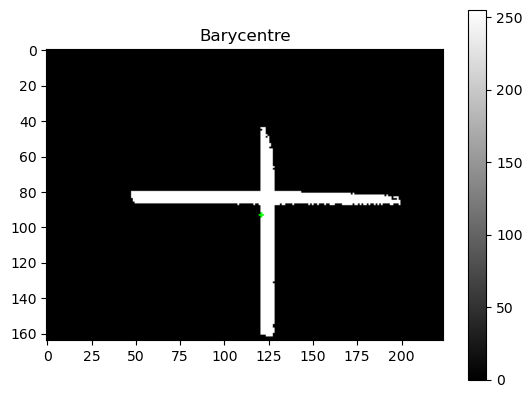

In [31]:
calculate_barycenter(image_binarisee)

## FTM
### FTM sur image complète

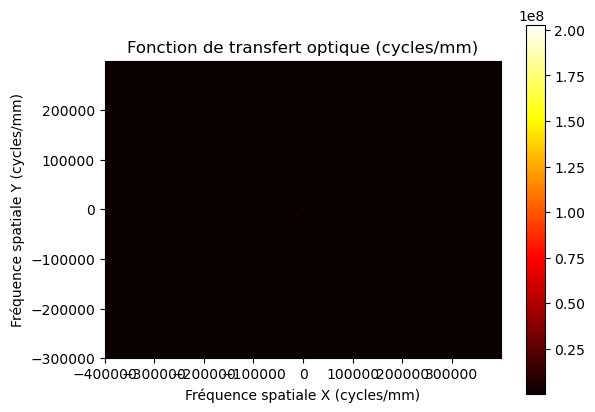

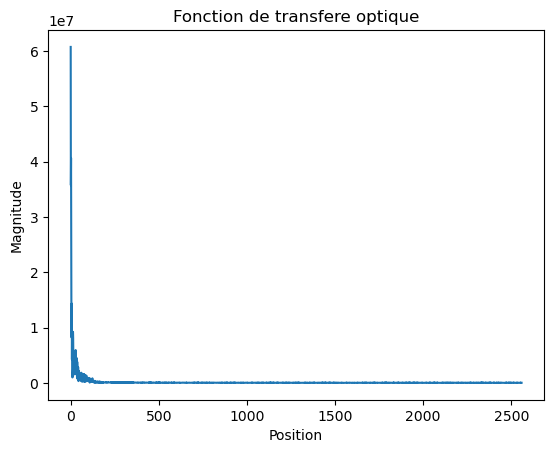

In [32]:
calculate_fourier_transform(image)

### FTM sur ROI

ROI_X_offset : 2448
ROI_Y_offset : 1838
ROI_largeur : 224
ROI_hauteur : 164


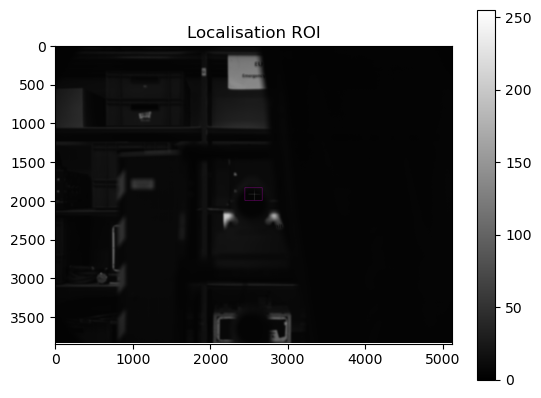

ROI 2672 5120 2002 3840
Création nouvelle image :  164 x 224


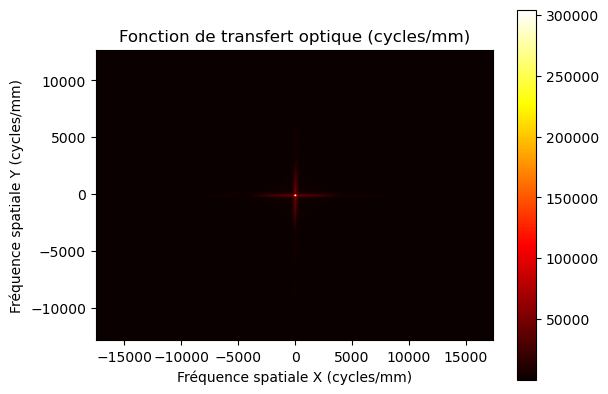

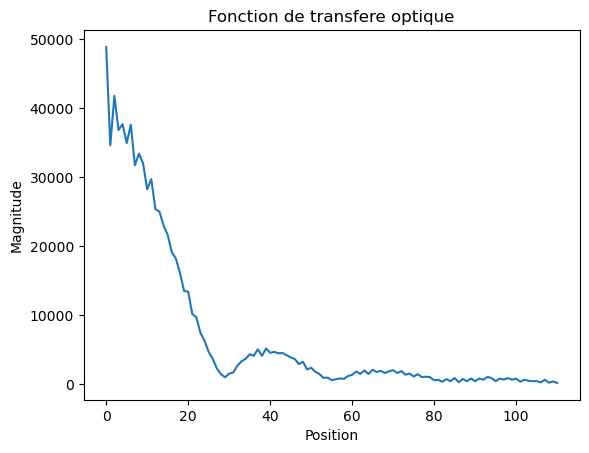

In [33]:
#Calcul de la luminance sur ROI
ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur=parse_configuration_file_ROI(config_path,"FTM")
visualisation_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
image_ROI_FTM=Make_ROI(image,ROI_offset_X,ROI_offset_Y, ROI_largeur, ROI_hauteur)
calculate_fourier_transform(image_ROI_FTM)

# Fin du programme

In [34]:
print ("terminée")
close_windows()

terminée
